In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Datasets Loading

In [2]:
# read the dataset with encoded categorical features
final_data = pd.read_csv(
    'https://raw.githubusercontent.com/Shakhtery/data-mining/main/Data/final_data.csv',
    index_col=0
)

# read the dataset with plain categorical features
final_data_raw = pd.read_csv(
    'https://raw.githubusercontent.com/Shakhtery/data-mining/main/Data/final_data_raw.csv',
    index_col=0
)

### Data Preparation Methods

Label encoding of `location`, `winner_name`, `loser_name` attributes

In [3]:
def label_encoding(df):
    df["location"] = df["location"].astype('category').cat.codes

    conc_names = pd.concat([df["player_1_name"], df["player_2_name"]]).astype('category').cat.codes
    df["player_1_name"] = conc_names.iloc[:len(conc_names)//2]
    df["player_2_name"] = conc_names.iloc[len(conc_names)//2:]

    return df

Date sorting and encoding: 
1. Sort rows by date.
2. Creates `sin` and `cos` features for `year`, `month`, `day` attributes retrieved from `date`

In [4]:
!pip install feature_engine

from feature_engine.creation import CyclicalFeatures
from datetime import datetime

def sort_by_date(df):
    return df.sort_values('date', ignore_index=True)

def encode_date(df):
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

    df["year"] = df["date"].apply(lambda x: x.year)
    df["month"] = df["date"].apply(lambda x: x.month)
    df["day"] = df["date"].apply(lambda x: x.day)

    cyclical = CyclicalFeatures(variables=None, drop_original=True)
    df = pd.concat([df, cyclical.fit_transform(df[["year", "month", "day"]])], axis=1)
    df = df.drop(["year", "month", "day"], axis=1)

    return df

One-hot Encoding of `court`, `surface`, `round`, `best_of`, `tourney_level`, `winner_hand`, `loser_hand`, `winner_ioc`, `loser_ioc` attributes

In [5]:
def one_hot_encoding(df):
    df = pd.concat([df, pd.get_dummies(df["court"])], axis=1).drop("court", axis=1)
    df = pd.concat([df, pd.get_dummies(df["surface"])], axis=1).drop("surface", axis=1)
    df = pd.concat([df, pd.get_dummies(df["round"])], axis=1).drop("round", axis=1)
    df = pd.concat([df, pd.get_dummies(df["best_of"])], axis=1).drop("best_of", axis=1)
    df = pd.concat([df, pd.get_dummies(df["tourney_level"])], axis=1).drop("tourney_level", axis=1)

    ohe_conc_players_hand = pd.get_dummies(pd.concat([df["player_1_hand"], df["player_2_hand"]]))
    df = pd.concat([df, ohe_conc_players_hand.iloc[:len(ohe_conc_players_hand)//2]], axis=1).drop("player_1_hand", axis=1)
    df = pd.concat([df, ohe_conc_players_hand.iloc[len(ohe_conc_players_hand)//2:]], axis=1).drop("player_2_hand", axis=1)

    ohe_conc_players_ioc = pd.get_dummies(pd.concat([df["player_1_ioc"], df["player_2_ioc"]]))
    df = pd.concat([df, ohe_conc_players_ioc.iloc[:len(ohe_conc_players_ioc)//2]], axis=1).drop("player_1_ioc", axis=1)
    df = pd.concat([df, ohe_conc_players_ioc.iloc[len(ohe_conc_players_ioc)//2:]], axis=1).drop("player_2_ioc", axis=1)

    return df

Standard scaling of `wrank`, `lrank`, `winner_ht`, `loser_ht`, `winner_age`, `loser_age` attibutes.  
Not included in preprocessing of the raw full dataset. Performed separately on train and test datasets.

In [6]:
def std_scale(series, mean, std):
    return (series-mean)/std

def scale(df):
    df = df.copy()
    concated = pd.concat([df["player_1_rank"], df["player_2_rank"]])
    mean = concated.mean()
    std = concated.std()
    df["player_1_rank"] = std_scale(df["player_1_rank"], mean, std)
    df["player_2_rank"] = std_scale(df["player_2_rank"], mean, std)

    concated = pd.concat([df["player_1_ht"], df["player_2_ht"]])
    mean = concated.mean()
    std = concated.std()
    df["player_1_ht"] = std_scale(df["player_1_ht"], mean, std)
    df["player_2_ht"] = std_scale(df["player_2_ht"], mean, std)

    concated = pd.concat([df["player_1_age"], df["player_2_age"]])
    mean = concated.mean()
    std = concated.std()
    df["player_1_age"] = std_scale(df["player_1_age"], mean, std)
    df["player_2_age"] = std_scale(df["player_2_age"], mean, std)

    return df

Small method for coverting column names to strings to avoid problems

In [7]:
def column_names_to_str(df):
    df.columns = df.columns.astype(str)
    return df

Raw full dataset preprocessing pipeline

In [8]:
def prepare_dataset(data):
    pipeline = [
        label_encoding,
        sort_by_date,
        encode_date,
        one_hot_encoding,
        #scale,
        column_names_to_str
    ]

    result = data.copy()
    for operation in pipeline:
        result = operation(result)

    return result

Method for splitting full dataset to train and test subsets

In [9]:
# train-test split
def train_test_split(X, Y, dates, train_end_year):
    mask = dates.dt.year <= train_end_year
    
    # if Y is 1-d vector there is a need to perform ravel()
    if Y.shape[1] == 1:
        Y = Y.to_numpy().ravel()
    
    return scale(X[mask]), Y[mask], scale(X[~mask]), Y[~mask]
    #return X[mask], Y[mask], X[~mask], Y[~mask]

### Data Preparation

In [10]:
full_dataset = prepare_dataset(final_data_raw) 

In [11]:
# target variables are probabilities of the first and the second players
target = ['player_1_won']

# include in predicting features all columns except 
# date(already encoded in the dataset) and data about odds
predictors = list(set(full_dataset.columns).difference({'player_1_won', 'player_2_won', 'date', 'maxw', 'maxl', 'avgw', 'avgl'}))
raw_predictors = list(set(final_data_raw.columns).difference({'player_1_won', 'player_2_won', 'date', 'maxw', 'maxl', 'avgw', 'avgl'}))

# Modeling

## Select Modeling Technique

### Modeling Techniques

The problem of the project can be formulated as a classification problem. The goal of the model therefore should be to assess probabilities of winning the first player and the second player in order to give betting tips afterwards. 

Decision of the model should also be based on how high the maximal winning probability of the two players is. It can probably make sense not to bet at all in some doubtful cases if we don't really want to lose money.

Even though the goal of the model is to assess the winning probabilities for both players, there is no need to create two models for both players since the events of Player 1 winning and Player 2 winning are opposite. It makes sense to take indicator column of the first player winning as a target feature.

The modelling techniques that meet the problem requirements may be:
* Logistic Regression
* Gaussian Naive Bayes 
* Decision Tree
* Nearest Neighbors Classifier
* Random Forest
* AdaBoost
* Neural Network
* SVM
* Gaussian Process
* Quadratic Discriminant Analysis

### Modelling Assumptions

* the predicting features must be numerical (not necessary for Decision Tree, Random Forest, AdaBoost)
* the target feature is binary indicating the winning of the first player in the play
* the model outputs the probabilities of winning for the players which are post-processed later to give no advice in doubtful cases
* the parameter related to detecting doubtful cases(confidence) is the hyperparameter of the model
* the confidence parameter is a value from [0; 0.5] indicating how much should the maximal probability exceed 0.5

## Generate Test Design

### Test Design

#### Training

Due to the temporal nature of the data, it makes sense to train the model on the data from the past years. So, the dataset should be ordered by date and the first $k$ years data should be selected for training.

#### Testing

The next years of data following by the training data are taken for testing the model.

The testing metric is going to be the following metric initially presented by our collegue Violetta Sim.

In the following code, `X0` is the initial bank size, can be set to 1 without any influence on the rest of the reasoning, and `p` is the percent of the bank we chose. It is suggested to use 10%. (`p` depends on the variance of the model; if it predicts accurately most of the time, it would be more profitable to increase it.)

```
X = X0
for play in dataset.rows:
	if (the model has predicted anything for the play):
		bet_amount = p*X
		if (model's prediction was correct):
			X += ((play's odds for the winner) - 1) * bet_amount
		else:
			X -= bet_amount

return X
```



The metric effectively shows how much money will left after betting following the model predictions. The metric greater than or equal to `X0` tells about quite good model performance since there is some income or saving at the end. The opposite case tells that the model shouldn't be used as a tipster model.



#### Evaluation

A custom order-preserved cross-validation[[1]](https://www.sciencedirect.com/science/article/pii/S2210832717301485) is going to be used for evaluation of the model. As it is demonstrated on the figure below, the dataset is separated in subsets by years. The training dataset starts with the first year(2000) and grows each each step by one new year. The model is trained on the training dataset and tested on subsequent years of match data. The model score is assessed. This happens until the training dataset covers the years 2000-2020. The score of the model is the average score. 

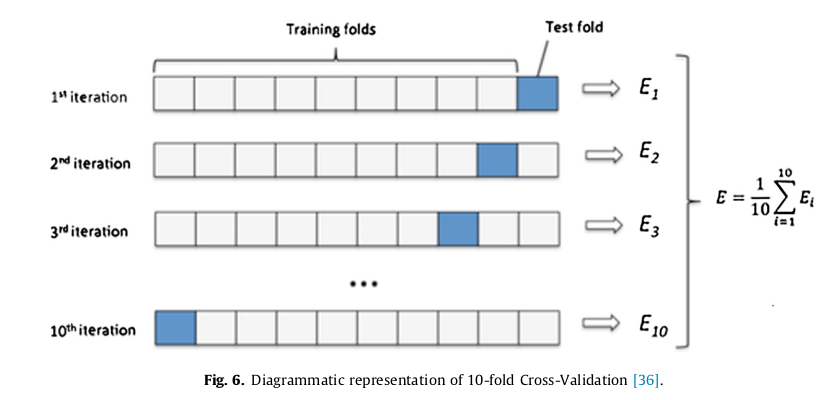

### Testing Methods

Method for splitting full dataset to train and test subsets

In [12]:
# train-test split
def train_test_split(X, Y, dates, train_end_year):
    mask = dates.dt.year <= train_end_year
    
    # if Y is 1-d vector there is a need to perform ravel()
    if Y.shape[1] == 1:
        Y = Y.to_numpy().ravel()
    
    return scale(X[mask]), Y[mask], scale(X[~mask]), Y[~mask]
    #return X[mask], Y[mask], X[~mask], Y[~mask]

The model metric

In [13]:
def sim_score(y, y_pred, winner_odds, p=0.1, init_bank=1):  
    cur_bank = init_bank
    for i in range(len(y)):
        if np.isnan(y_pred[i]) or pd.isna(winner_odds[i]):
            continue
        bet_amount = p * cur_bank
        cur_bank -= bet_amount
        if y_pred[i] == y[i]:
            cur_bank += winner_odds[i] * bet_amount
    return cur_bank

Method evaluating order-preserved cross-validation score(for preprocessed dataset)

In [14]:
def cv_score(model):
    scores = []
    for train_end_year in range(2000, 2020):
        X_train, y_train, X_test, y_test = train_test_split(
            full_dataset[predictors],
            full_dataset[target],
            full_dataset['date'],
            train_end_year
        )
        model.fit(X_train, y_train)
        scores.append(sim_score(y_test, model.predict(X_test), full_dataset.iloc[X_test.index]['avgw'].to_numpy()))
    return np.mean(scores)

## Build Model

### Model Implementations

#### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

class LRTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.lr = LogisticRegression(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.lr.fit(X, player_1_won)

    def predict(self, X):
        probs = self.lr.predict_proba(X)
        predictions = self.lr.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Gaussian Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

class GaussianNBTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.nb = GaussianNB(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.nb.fit(X, player_1_won)

    def predict(self, X):
        probs = self.nb.predict_proba(X)
        predictions = self.nb.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

class DecisionTreeTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = DecisionTreeClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

class KNNTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = KNeighborsClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = RandomForestClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostClassifier

class AdaBoostTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = AdaBoostClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Neural Network

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class NNTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = Pipeline([
            ('scaler', StandardScaler()),
            ('nn', MLPClassifier(**kwargs))
        ])
        #self.clf = MLPClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### SVM

In [77]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class SVMTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(**kwargs))
        ])
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Gaussian Process

In [20]:
from sklearn.gaussian_process import GaussianProcessClassifier

class GaussianProcessTipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = GaussianProcessClassifier(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

#### Quadratic Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

class QDATipsterModel:
    def __init__(self, confidence=0.25, **kwargs):
        self.clf = QuadraticDiscriminantAnalysis(**kwargs)
        self.confidence = confidence
        
    def fit(self, X, player_1_won):
        self.clf.fit(X, player_1_won)

    def predict(self, X):
        probs = self.clf.predict_proba(X)
        predictions = self.clf.predict(X)
        notsure_mask = np.maximum(probs[:, 0], probs[:, 1]) - 0.5 < self.confidence
        predictions = predictions.astype('float32')
        predictions[notsure_mask] = np.nan
        return predictions

### Parameter Settings

#### Grid Search

For each model there are going to be multiple values for certain model parameters. The final values of the model parameters will be selecting using cross-validation score. The parameter configuration with the highest score is going to be the final configuration

In [16]:
import itertools
from tqdm import tqdm

def grid_search(estimator, param_grid):
    confs = list(itertools.product(*param_grid.values()))
    scores = []
    for conf in tqdm(confs):
        args = dict(zip(param_grid.keys(), conf))
        model = estimator(**args)
        scores.append(cv_score(model))

    return confs[np.argmax(scores)]

#### Logistic Regression

Grid of parameters. For this model it is particularly interesting how regularization parameters(`penalty`, `C`) affect the model. It is also necessary to check whether there is a need for class balancing(`class_weight`). The `solver` is chosen to be liblinear since it works fast with small datasets and allows regularization. The confidence parameter provided is quite high since it was noticed that it is not profitable to take confidence lower than 0.4

In [ ]:
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C' : np.linspace(0.01, 0.1, 5),
    'class_weight': ['balanced', None],
    'solver': ['liblinear'], 
    'confidence': np.linspace(0.49, 0.5, 11)
}
lr_param_grid

{'C': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
 'class_weight': ['balanced', None],
 'confidence': array([0.49 , 0.491, 0.492, 0.493, 0.494, 0.495, 0.496, 0.497, 0.498,
        0.499, 0.5  ]),
 'penalty': ['l1', 'l2'],
 'solver': ['liblinear']}

Grid search

In [ ]:
grid_search(LRTipsterModel, lr_param_grid)

100%|██████████| 220/220 [53:01<00:00, 14.46s/it]


('l1', 0.0325, 'balanced', 'liblinear', 0.498)

The parameters for logistic regression model selected by grid search are:

In [31]:
lr_params = {
    'penalty': 'l1',
    'C': 0.325,
    'class_weight': 'balanced',
    'solver': 'liblinear',
    'confidence': 0.498
}

#### Gaussian Naive Bayes

Grid of parameters. The only interesting parameter of the model for us is `var_smoothing`.

In [ ]:
gnb_param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'confidence': np.linspace(0.49, 0.5, 11)
}
gnb_param_grid

{'confidence': array([0.49 , 0.491, 0.492, 0.493, 0.494, 0.495, 0.496, 0.497, 0.498,
        0.499, 0.5  ]),
 'var_smoothing': [1e-10,
  1e-09,
  1e-08,
  1e-07,
  1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1]}

Grid search

In [ ]:
grid_search(GaussianNBTipsterModel, gnb_param_grid)

100%|██████████| 110/110 [16:46<00:00,  9.15s/it]


(1e-05, 0.499)

The parameter of Gaussian Naive Bayes model is:

In [41]:
gnb_params = {
    'var_smoothing': 1e-5,
    'confidence': 0.499
}

#### Decision Tree

Grid of paramters

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
    'confidence': np.linspace(0.49, 0.5, 3)
}
dt_param_grid

{'class_weight': [None, 'balanced'],
 'confidence': array([0.49 , 0.495, 0.5  ]),
 'criterion': ['gini', 'entropy'],
 'max_features': [None, 'sqrt', 'log2'],
 'splitter': ['best', 'random']}

Grid Search

In [ ]:
grid_search(DecisionTreeTipsterModel, dt_param_grid)

100%|██████████| 72/72 [17:04<00:00, 14.23s/it]


('gini', 'best', None, 'balanced', 0.5)

The parameters of the decision tree are:

In [49]:
dt_params = {
    'criterion': 'gini',
    'splitter': 'best',
    'max_features': None,
    'class_weight': 'balanced',
    'confidence': 0.5
}

#### KNN

Grid of parameters. Ball tree is chosen since it works faster in higher dimensions

In [ ]:
knn_param_grid = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree'],
    'p': [1, 2],
    'confidence': np.linspace(0.49, 0.5, 3)
}
knn_param_grid

{'algorithm': ['ball_tree'],
 'confidence': array([0.49 , 0.495, 0.5  ]),
 'p': [1, 2],
 'weights': ['uniform', 'distance']}

Grid search

In [ ]:
grid_search(KNNTipsterModel, knn_param_grid)

100%|██████████| 12/12 [36:42<00:00, 183.56s/it]


('uniform', 'ball_tree', 2, 0.49)

The final configuration

In [55]:
knn_params = {
    'weights': 'uniform',
    'algorithm': 'ball_tree',
    'p': 2,
    'confidence': 0.49
}

#### Random Forest

Grid of parameters. Gini index, max_features=None, balanced class weight are chosen since they were the best for decision tree classifier. Bootstap is set since it builds the forest faster.

In [ ]:
rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini'],
    'max_depth': [1, 5, 10],
    'max_features': [None],
    'bootstrap': [True],
    'class_weight': ['balanced'],
    'confidence': np.linspace(0.49, 0.5, 3)
}
rf_param_grid

{'bootstrap': [True],
 'class_weight': ['balanced'],
 'confidence': array([0.49 , 0.495, 0.5  ]),
 'criterion': ['gini'],
 'max_depth': [1, 5, 10],
 'max_features': [None],
 'n_estimators': [10, 50, 100]}

Grid search

In [ ]:
grid_search(RandomForestTipsterModel, rf_param_grid)

100%|██████████| 27/27 [1:18:53<00:00, 175.32s/it]


(10, 'gini', 10, None, True, 'balanced', 0.49)

The final configuration

In [59]:
rf_params = {
    'n_estimators': 10,
    'criterion': 'gini',
    'max_depth': 10,
    'max_features': None,
    'bootstrap': True,
    'class_weight': 'balanced',
    'confidence': 0.49
}

#### AdaBoost

Grid of parameters

In [ ]:
ab_param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.5, 1, 1.5],
    'algorithm': ['SAMME', 'SAMME.R'],
    'confidence': np.linspace(0.49, 0.5, 3)
}
ab_param_grid

{'algorithm': ['SAMME', 'SAMME.R'],
 'confidence': array([0.49 , 0.495, 0.5  ]),
 'learning_rate': [0.5, 1, 1.5],
 'n_estimators': [10, 50, 100]}

Grid search

In [28]:
grid_search(AdaBoostTipsterModel, ab_param_grid)

100%|██████████| 54/54 [1:29:03<00:00, 98.95s/it] 


(10, 0.5, 'SAMME', 0.49)

The final configuration

In [64]:
ab_params = {
    'n_estimators': 10,
    'learning_rate': 0.5,
    'algorithm': 'SAMME',
    'confidence': 0.49
}

#### Neural Network

Grid of parameters

In [61]:
nn_param_grid = {
    'hidden_layer_sizes': [(150, 50)],
    'activation': ['relu', 'logistic', 'tanh'],
    'early_stopping': [True],
    'shuffle': [False],
    'learning_rate': ['adaptive'],
    'solver': ['adam'],
    'confidence': np.linspace(0.49, 0.5, 3)
}
nn_param_grid

{'activation': ['relu', 'logistic', 'tanh'],
 'confidence': array([0.49 , 0.495, 0.5  ]),
 'early_stopping': [True],
 'hidden_layer_sizes': [(150, 50)],
 'learning_rate': ['adaptive'],
 'shuffle': [False],
 'solver': ['adam']}

Grid search

In [62]:
grid_search(NNTipsterModel, nn_param_grid)

100%|██████████| 9/9 [42:30<00:00, 283.40s/it]


((150, 50), 'relu', True, False, 'adaptive', 'adam', 0.5)

The final configuration

In [72]:
nn_params = {
    'hidden_layer_sizes': (150, 50),
    'activation': 'relu',
    'early_stopping': True,
    'shuffle': False,
    'learning_rate': 'adaptive',
    'solver': 'adam',
    'confidence': 0.5
}

#### SVM

The final configuration is the following. Grid search hasn't been done due to longer duration of the classifier training. Kernel RBF is selected since it is the default choice. Confidence is the median since we don't know which option is better: 0.49 or 0.5. Cache size and shrinking is selected since this configuration allows to accelerate somehow the classifier training. The probabiliry option is selected since we really need probability estimations for our case. 

In [76]:
svm_params = {
    'kernel': 'rbf',
    'confidence': 0.495,
    'cache_size': 1024 * 5,
    'shrinking': True,
    'class_weight': 'balanced',
    'probability': True
}

#### Gaussian Process

Here are the final parameters of the model. All other parameters are to be default. Cross-validation of this model takes much time, so it is decided to select the default ones. Confidence is select to be in the middle.

In [1]:
gp_params = {
    'copy_X_train': False,
    'confidence': 0.495
}

#### Quadratic Discriminant Analysis

Grid of parameters. Due to poor knowledge of how this model works, it is decided to take other parameters to be default.

In [18]:
qda_param_grid = {
    'confidence': np.linspace(0.49, 0.5, 3)
}
qda_param_grid

{'confidence': array([0.49 , 0.495, 0.5  ])}

Grid search. There could be seen some problems with applying of the model on our case.

In [19]:
grid_search(QDATipsterModel, qda_param_grid)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python

(0.5,)

The confidence parameter for the model is chosen to be 0.5. Most probably, the model performs quite poor.

In [19]:
qda_params = {
    'confidence': 0.5
}

### Models

The models are going to be trained on 70% of the data which is the data from 2000 to 2014 years. The trained models are saved as a python object is separate files.

In [16]:
import pickle

In [17]:
X_train, y_train, X_test, y_test = train_test_split(
    full_dataset[predictors],
    full_dataset[target],
    full_dataset['date'],
    2014
)

#### Logistic Regression

In [34]:
clf = LRTipsterModel(**lr_params)

In [35]:
clf.fit(X_train, y_train)

In [37]:
with open('logistic_regression', 'wb') as file:
    pickle.dump(clf, file)

#### Gaussian Naive Bayes

In [50]:
clf = GaussianNBTipsterModel(**gnb_params)

In [43]:
clf.fit(X_train, y_train)

In [44]:
with open('gaussian_nb', 'wb') as file:
    pickle.dump(clf, file)

#### Decision Tree

In [51]:
clf = DecisionTreeTipsterModel(**dt_params)

In [52]:
clf.fit(X_train, y_train)

In [53]:
with open('decision_tree', 'wb') as file:
    pickle.dump(clf, file)

#### KNN

In [56]:
clf = KNNTipsterModel(**knn_params)

In [57]:
clf.fit(X_train, y_train)

In [58]:
with open('knn', 'wb') as file:
    pickle.dump(clf, file)

#### Random Forest

In [61]:
clf = RandomForestTipsterModel(**rf_params)

In [62]:
clf.fit(X_train, y_train)

In [63]:
with open('random_forest', 'wb') as file:
    pickle.dump(clf, file)

#### AdaBoost

In [66]:
clf = AdaBoostTipsterModel(**ab_params)

In [67]:
clf.fit(X_train, y_train)

In [68]:
with open('ada_boost', 'wb') as file:
    pickle.dump(clf, file)

#### Neural Network

In [73]:
clf = NNTipsterModel(**nn_params)

In [74]:
clf.fit(X_train, y_train)

In [75]:
with open('nn', 'wb') as file:
    pickle.dump(clf, file)

#### SVM

In [78]:
clf = SVMTipsterModel(**svm_params)

In [79]:
clf.fit(X_train, y_train)

In [80]:
with open('svm', 'wb') as file:
    pickle.dump(clf, file)

#### Gaussian Process

Cannot train due to running out of memory

#### Quadratic Discriminant Analysis

In [20]:
clf = QDATipsterModel(**qda_params)

In [21]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [22]:
with open('qda', 'wb') as file:
    pickle.dump(clf, file)

#### Models Folder

https://drive.google.com/drive/folders/1BIyhADfRQ5eRxi0jcm12Px_CnZz4BV-5?usp=sharing

### Model Descriptions